In [17]:
import numpy as np

# *Exercise 1*: A few questions about machine learning to see whether you've read the text and watched the videos. 
#### What do we mean by a 'feature' in a machine learning model?
A feature is simply a label, or a representation of something distinguished between others.

#### What is the main problem with overfitting?
Overfitting occurs, when the model becomes too good to predict the training data, that it generally performs badly on the test data.

#### Explain the connection between the bias-variance trade-off and overfitting/underfitting.
Something something

#### The `Luke is for leukemia` on page 145 in the reading is a great example of why accuracy is not a good measure in very unbalanced problems. Try to come up with a similar example based on a different type of data (either one you are interested in or one related to the SF crime dataset).
The problem with accuracy is, that it does not tell os how correalated the test results are. In the luke example we see, that the reason for the high accuracy is the high number of true negatives, simply because the number of people without leukemia and not named Luke is very high compare to the rest of the dataset. We *recall* that the formula for accuracy is:

$$
acc = \frac{tp + tn}{tp + tn + fp + fn}
$$

Another example of this would be to compare how often a person driving a bmw is called Anna-Maria. Of course this name is not very common in Denmark, and thus the accuracy would be high, something something.

# **Exercise 2**


# **Exercise 3**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv("../files/recidivism_dataset_sub.csv")

## **Exercise 3.1**
Create dataframe from variables of interest and our target

In [20]:
variables_of_interest = [
    # Variables
    "age",
    "sex",
    "race",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "is_recid",
    "days_b_screening_arrest",
    "c_charge_degree",

    # Feature
    "two_year_recid"  
]
data = df[variables_of_interest]
print(data.shape)

(7214, 11)


## **Exercise 3.2**

### **Preprocessing**
* To preprocess the data follow these steps:
  * filter out records where the `is_recid` feature is not known (i.e. where it is equal to -1); 
  * only keep records that cause jail time;
  * only keep records that have between $-30$ and $30$ days between the arrest and screening.
  * Finally, drop `is_recid`, `c_charge_degree`, `days_b_screening_arrest` for the upcoming analysis.

In [21]:
# Is recid if victim has made a crime after a conviction.
# Dropping all where this isn't answered
data = data[data.is_recid > -1]

# Dropping all where the charge does not result in jail time.
data = data[data.c_charge_degree != "O"]

# Dropping all where the records are not between -30 and 30 days.
data = data[(data.days_b_screening_arrest >= -30) &  (data.days_b_screening_arrest <= 30)]

# Dropping columns
data.drop(["is_recid", "c_charge_degree", "days_b_screening_arrest"], inplace=True, axis=1)

## Data 

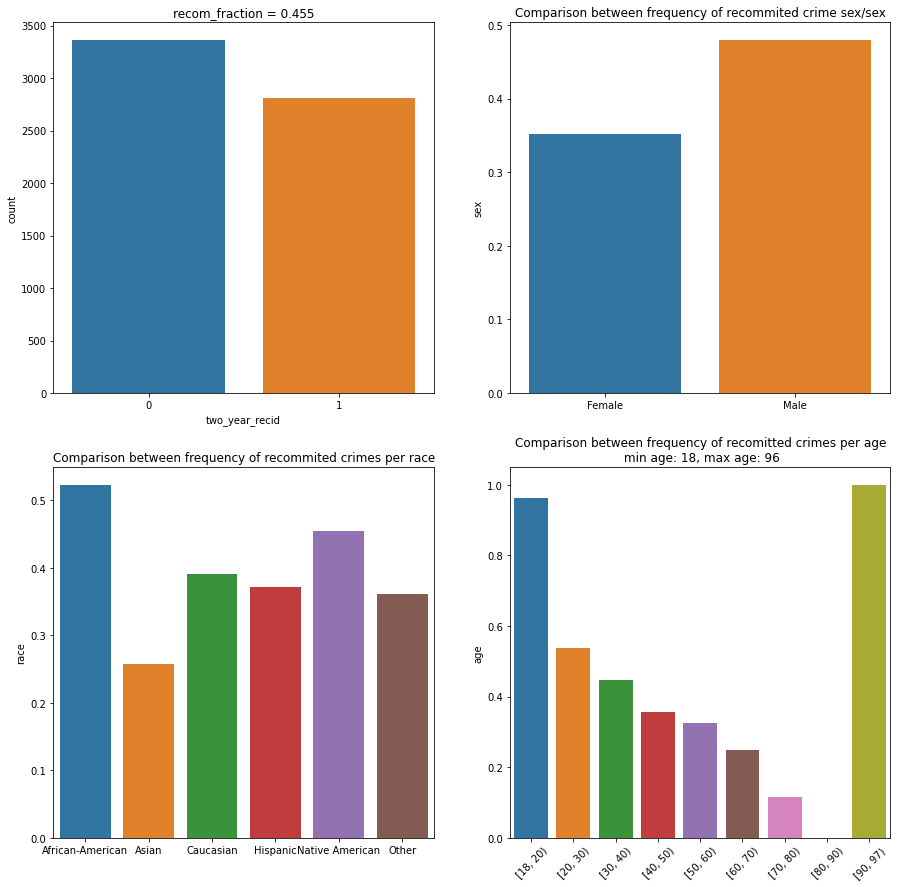

In [22]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15, 15))

recom_fraction = data[data.two_year_recid == 1].shape[0] / data.shape[0]

ax1.set_title(f"{recom_fraction = :.3f}");
sns.countplot(x="two_year_recid", data=data, ax=ax1)

sex_data = data[data.two_year_recid == 1].sex.value_counts().sort_index() / data.sex.value_counts().sort_index()
sns.barplot(x=sex_data.index, y=sex_data, ax=ax2)
ax2.set_title("Comparison between frequency of recommited crime sex/sex")

race_data = data[data.two_year_recid == 1].race.value_counts().sort_index() / data.race.value_counts().sort_index()
sns.barplot(x=race_data.index, y=race_data, ax=ax3)
ax3.set_title("Comparison between frequency of recommited crimes per race")

# Cutting the data into buckets
age_bins = [18, 20, 30, 40, 50, 60, 70, 80, 90, 97]
age_recom_data = pd.cut(data[data.two_year_recid == 1].age, bins=age_bins, right=False).value_counts().sort_index()
age_overall_data = pd.cut(data.age, bins=age_bins, right=False).value_counts().sort_index()
age_data = age_recom_data / age_overall_data
sns.barplot(x=age_data.index, y=age_data, ax=ax4)
ax4.set_xticklabels(age_data.index, rotation=45)
ax4.set_title(f"Comparison between frequency of recomitted crimes per age\n min age: {df.age.min()}, max age: {df.age.max()}");

## **Exercise 3.2 - extended**
**What are encoders**: Translaters between string values and numeric values

**Values we need to transform**:
- Sex
- Race

In [23]:
data.sample()

,age,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid
3800,24,Male,African-American,0,0,4,8,1


## **Exercise 3.3**

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [25]:
oh_features = ["sex", "race"]
features = pd.concat([
    data,
    pd.get_dummies(data[oh_features])
    ], axis=1).drop(oh_features, axis=1)

In [26]:
target_col = "two_year_recid"

# Creating labels
labels = features[target_col].to_numpy()

# Seperate variables and target
features = features.drop(target_col, axis=1)

# Saving feature names for later
feature_list = list(features.columns)

# Converting features to np array
features = features.to_numpy()

### **Creating test and training set**

In [27]:
# Creating test and train set
train_x, test_x, train_Y, test_Y = train_test_split(features, labels, test_size=.3, random_state=42, stratify=data[target_col])

### **Training model**

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_x, train_Y)

RandomForestClassifier(random_state=42)

In [30]:
# Predicting
predictions = rf.predict(test_x)

# Finding accuracy
accuracy = accuracy_score(test_Y, predictions)
recall = recall_score(test_Y, predictions)
precision = precision_score(test_Y, predictions)

print(f"{accuracy = :.3f}\n{recall = :.3f}\n{precision = :.3f}")

accuracy = 0.642
recall = 0.536
precision = 0.624


In [31]:
# Hyper parameter tuning using grid
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of decision trees
n_estimators = list(map(int, list(np.linspace(200, 2000, num=10))))

# Number of features to consider at every split
max_features = ["auto", "sqrt"]

# Max number of levels in decision trees
max_depth = list(np.linspace(10, 110, 11))
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10.0,
               20.0,
               30.0,
               40.0,
               50.0,
               60.0,
               70.0,
               80.0,
               90.0,
               100.0,
               110.0,
               None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [32]:
# Creating new random forest
rf = RandomForestClassifier()

# Random search of parameters using 3 fold cross validation
# Search through 100 different configs and use all cores
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose = 2,
                               random_state = 42,
                               n_jobs = -1)

rf_random.fit(test_x, test_Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30.0, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30.0, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30.0, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=30.0, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.3s
[CV] END bootstrap=False, max_depth=10.0, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=10.0, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.9s
[CV] END bootstrap=False, max_depth=30.0, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10.0, 20.0, 30.0, 40.0,
                                                      50.0, 60.0, 70.0, 80.0,
                                                      90.0, 100.0, 110.0,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [33]:
predictions = rf_random.predict(test_x)
def report(model: RandomForestClassifier):
    preds = model.predict(test_x)
    return pd.DataFrame(
        classification_report(test_Y, 
                              preds, 
                              labels=[0, 1], 
                              target_names = ["Repeat Offender", "Non Repeat Offender"], 
                              output_dict=True)
        ).T

def improvement(bas_model: RandomForestClassifier, bes_model: RandomForestClassifier):
    base_preds = bas_model.predict(test_x)
    best_preds = bes_model.predict(test_x)
    
    base_acc = accuracy_score(test_Y, base_preds)
    best_acc = accuracy_score(test_Y, best_preds)
    
    return f"Improvement: {(best_acc - base_acc) / base_acc * 100 :.2f} %" 

In [57]:
base_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
base_model.fit(train_x, train_Y)
report(base_model)

,precision,recall,f1-score,support
Repeat Offender,0.675144,0.815659,0.738779,1009.000000
Non Repeat Offender,0.706161,0.530249,0.605691,843.000000
accuracy,0.685745,0.685745,0.685745,0.685745
macro avg,0.690652,0.672954,0.672235,1852.000000
weighted avg,0.689262,0.685745,0.678200,1852.000000


In [35]:
best_random = rf_random.best_estimator_
report(best_random)

,precision,recall,f1-score,support
Repeat Offender,0.725000,0.833499,0.775473,1009.000000
Non Repeat Offender,0.757225,0.621590,0.682736,843.000000
accuracy,0.737041,0.737041,0.737041,0.737041
macro avg,0.741113,0.727544,0.729104,1852.000000
weighted avg,0.739668,0.737041,0.733260,1852.000000


In [36]:
improvement(base_model, best_random)

'Improvement: 14.80 %'

In [37]:
pprint(best_random.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 90.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "bootstrap": [True],
    "max_depth": [80, 90, 100, 110],
    "max_features": [2, 3],
    "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [3, 5, 7],
    "n_estimators": [100, 800, 900, 1000, 1100]
}

rf = RandomForestClassifier() 

grid_search = GridSearchCV(estimator=rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose=3)

In [39]:
grid_search.fit(train_x, train_Y)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV 2/3] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.670 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.669 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.667 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.664 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.669 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.672 total time=   0.3s
[CV 1/3] END bootstrap=True, max_dep

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [100, 800, 900, 1000, 1100]},
             verbose=3)

In [40]:
report(grid_search.best_estimator_)

,precision,recall,f1-score,support
Repeat Offender,0.682125,0.801784,0.737130,1009.000000
Non Repeat Offender,0.699700,0.552788,0.617628,843.000000
accuracy,0.688445,0.688445,0.688445,0.688445
macro avg,0.690912,0.677286,0.677379,1852.000000
weighted avg,0.690125,0.688445,0.682734,1852.000000


In [43]:
improvement(base_model, grid_search.best_estimator_)

'Improvement: 7.23 %'

In [44]:
from sklearn import tree

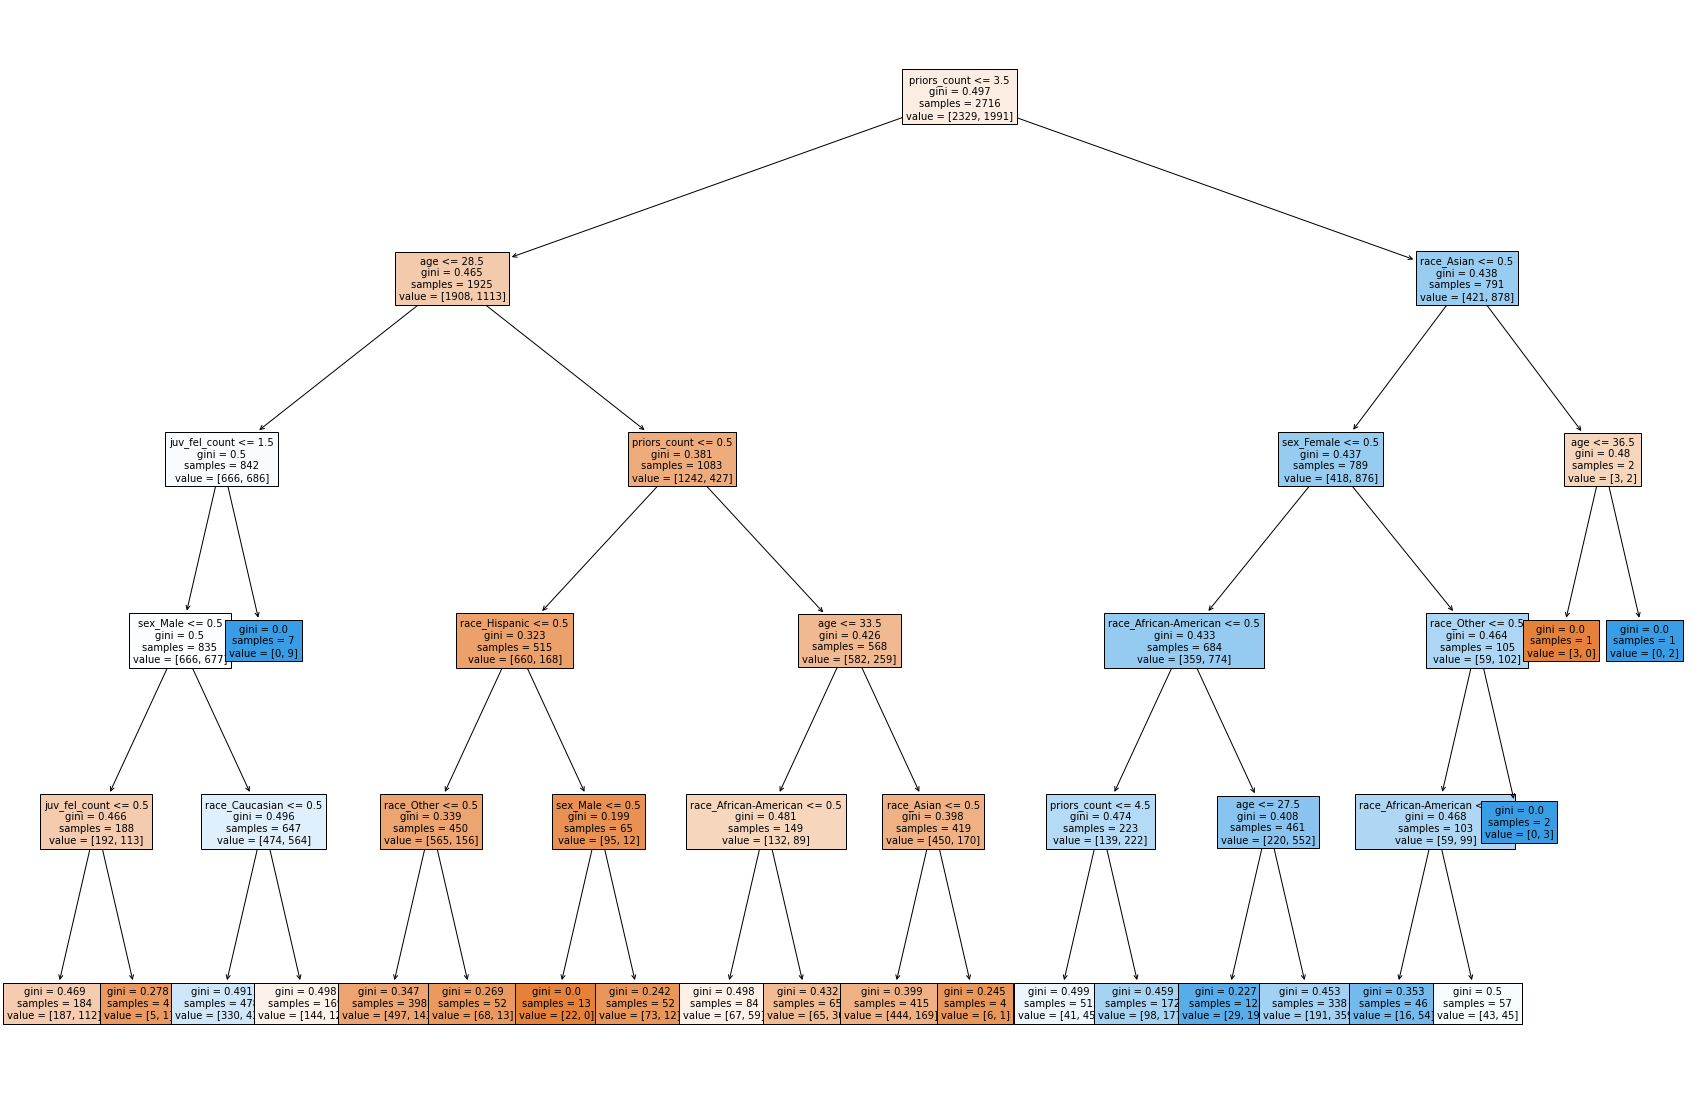

In [59]:
plt.figure(figsize=(30, 20))
tree.plot_tree(base_model.estimators_[0],
               feature_names=feature_list,
               fontsize=10,
               filled=True);

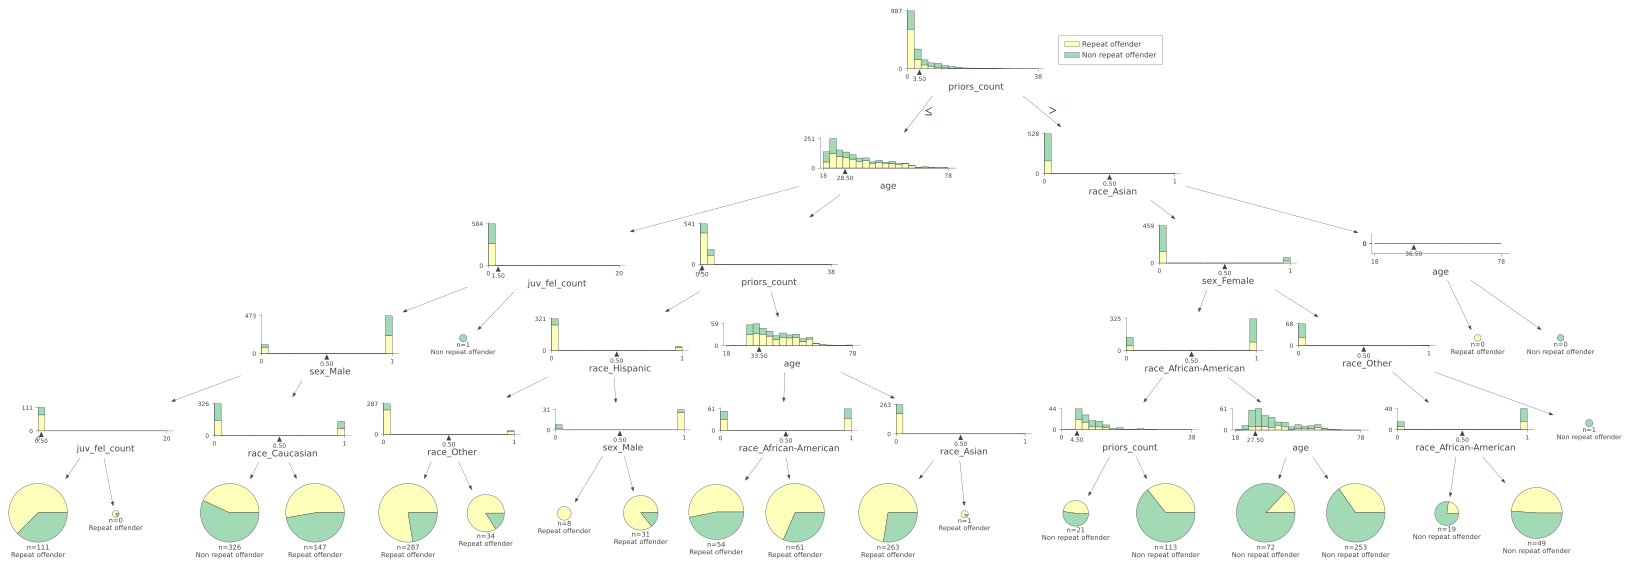

In [63]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(base_model.estimators_[0],
               test_x,
               test_Y,
               feature_names=feature_list,
               class_names=["Repeat offender", "Non repeat offender"])
viz